#Convolutional Neural Networks (CNNs)

##Q1)

###Imports


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###Data Setup


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 22.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 607kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.81MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.47MB/s]


###Baseline CNN

In [18]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))      # Conv → ReLU
        x = F.max_pool2d(x, 2)         # MaxPool
        x = F.relu(self.conv2(x))      # Conv → ReLU
        x = F.max_pool2d(x, 2)         # MaxPool
        x = torch.flatten(x, 1)        # Flatten
        x = F.relu(self.fc1(x))        # Dense → ReLU
        x = self.dropout(x)            # Dropout(0.5)
        x = self.fc2(x)                # Dense(10)
        return F.log_softmax(x, dim=1) # Softmax

model = CNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

####Train and Test

In [10]:
train_losses, test_losses, accuracies = [], [], []

for epoch in range(1, 11):
    model.train()
    running_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    test_losses.append(test_loss / len(test_loader))
    accuracy = correct / len(test_loader.dataset)
    accuracies.append(accuracy)
    print(f"Epoch {epoch}: Train Loss = {train_losses[-1]:.4f}, Test Loss = {test_losses[-1]:.4f}, Accuracy = {accuracy:.4f}")

Epoch 1: Train Loss = 0.2111, Test Loss = 0.0430, Accuracy = 0.9858
Epoch 2: Train Loss = 0.0753, Test Loss = 0.0320, Accuracy = 0.9889
Epoch 3: Train Loss = 0.0590, Test Loss = 0.0314, Accuracy = 0.9898
Epoch 4: Train Loss = 0.0486, Test Loss = 0.0271, Accuracy = 0.9906
Epoch 5: Train Loss = 0.0404, Test Loss = 0.0263, Accuracy = 0.9920
Epoch 6: Train Loss = 0.0344, Test Loss = 0.0238, Accuracy = 0.9922
Epoch 7: Train Loss = 0.0316, Test Loss = 0.0273, Accuracy = 0.9922
Epoch 8: Train Loss = 0.0266, Test Loss = 0.0269, Accuracy = 0.9922
Epoch 9: Train Loss = 0.0250, Test Loss = 0.0229, Accuracy = 0.9933
Epoch 10: Train Loss = 0.0217, Test Loss = 0.0275, Accuracy = 0.9930


####Graphs

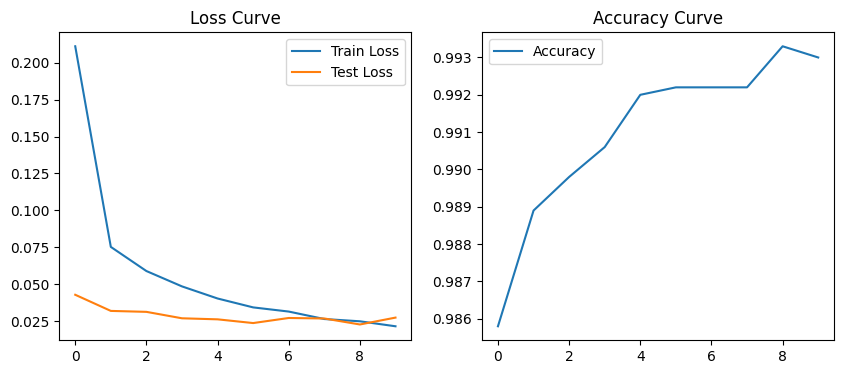

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(accuracies, label='Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

##Q2)

### 2.1)DeepCNN

In [5]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.dropout = nn.Dropout(0.5)

        # calculate fc input size
        self._to_linear = None
        self._init_linear_layer()

        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 10)

    def _init_linear_layer(self):   # i got error so, i added here to avoid it
        with torch.no_grad():
            x = torch.zeros(1, 1, 28, 28)
            x = self.conv1(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2)
            x = self.conv2(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2)
            x = self.conv3(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2)
            self._to_linear = x.view(1, -1).shape[1]

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
model = DeepCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

####Train and Test

In [7]:
train_losses, test_losses, accuracies = [], [], []

for epoch in range(1, 11):
    model.train()
    running_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    test_losses.append(test_loss / len(test_loader))
    accuracy = correct / len(test_loader.dataset)
    accuracies.append(accuracy)
    print(f"Epoch {epoch}: Train Loss = {train_losses[-1]:.4f}, Test Loss = {test_losses[-1]:.4f}, Accuracy = {accuracy:.4f}")

Epoch 1: Train Loss = 0.2906, Test Loss = 0.0844, Accuracy = 0.9758
Epoch 2: Train Loss = 0.0910, Test Loss = 0.0590, Accuracy = 0.9820
Epoch 3: Train Loss = 0.0663, Test Loss = 0.0574, Accuracy = 0.9826
Epoch 4: Train Loss = 0.0528, Test Loss = 0.0469, Accuracy = 0.9857
Epoch 5: Train Loss = 0.0451, Test Loss = 0.0485, Accuracy = 0.9861
Epoch 6: Train Loss = 0.0333, Test Loss = 0.0454, Accuracy = 0.9881
Epoch 7: Train Loss = 0.0298, Test Loss = 0.0434, Accuracy = 0.9890
Epoch 8: Train Loss = 0.0283, Test Loss = 0.0582, Accuracy = 0.9859
Epoch 9: Train Loss = 0.0222, Test Loss = 0.0516, Accuracy = 0.9857
Epoch 10: Train Loss = 0.0204, Test Loss = 0.0545, Accuracy = 0.9880


####Graphs

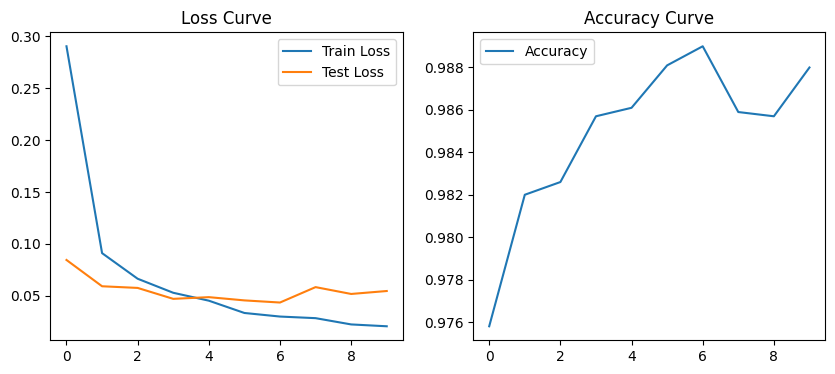

In [8]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(accuracies, label='Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

### 2.2) Different Kernel CNN

In [9]:
class KernelCNN(nn.Module):
    def __init__(self):
        super(KernelCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)     # 5x5 kernel
        self.conv2 = nn.Conv2d(32, 64, kernel_size=1)               # 1x1 kernel
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)   # 3x3 kernel
        self.dropout = nn.Dropout(0.5)

        self._to_linear = None
        self._init_linear_layer()

        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 10)

    def _init_linear_layer(self):
        with torch.no_grad():
            x = torch.zeros(1, 1, 28, 28)
            x = F.relu(self.conv1(x))
            x = F.max_pool2d(x, 2)
            x = F.relu(self.conv2(x))
            x = F.max_pool2d(x, 2)
            x = F.relu(self.conv3(x))
            x = F.max_pool2d(x, 2)
            self._to_linear = x.view(1, -1).shape[1]

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [10]:
model = KernelCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

####Training and Test

In [11]:
train_losses, test_losses, accuracies = [], [], []

for epoch in range(1, 11):
    model.train()
    running_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    test_losses.append(test_loss / len(test_loader))
    accuracy = correct / len(test_loader.dataset)
    accuracies.append(accuracy)
    print(f"Epoch {epoch}: Train Loss = {train_losses[-1]:.4f}, Test Loss = {test_losses[-1]:.4f}, Accuracy = {accuracy:.4f}")

Epoch 1: Train Loss = 0.2468, Test Loss = 0.0444, Accuracy = 0.9843
Epoch 2: Train Loss = 0.0783, Test Loss = 0.0343, Accuracy = 0.9899
Epoch 3: Train Loss = 0.0566, Test Loss = 0.0328, Accuracy = 0.9892
Epoch 4: Train Loss = 0.0490, Test Loss = 0.0255, Accuracy = 0.9919
Epoch 5: Train Loss = 0.0393, Test Loss = 0.0319, Accuracy = 0.9908
Epoch 6: Train Loss = 0.0354, Test Loss = 0.0317, Accuracy = 0.9899
Epoch 7: Train Loss = 0.0316, Test Loss = 0.0265, Accuracy = 0.9911
Epoch 8: Train Loss = 0.0266, Test Loss = 0.0271, Accuracy = 0.9915
Epoch 9: Train Loss = 0.0249, Test Loss = 0.0262, Accuracy = 0.9919
Epoch 10: Train Loss = 0.0214, Test Loss = 0.0278, Accuracy = 0.9926


####Graph

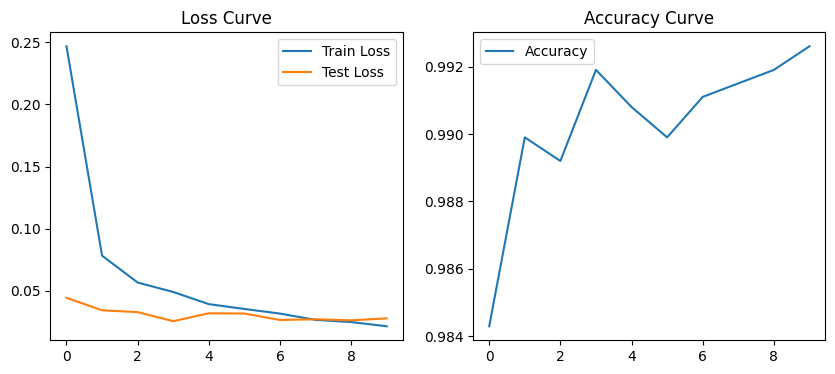

In [12]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(accuracies, label='Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

### 2.3) LeakyRELU CNN

In [13]:
class LeakyReLUCNN(nn.Module):
    def __init__(self):
        super(LeakyReLUCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.dropout = nn.Dropout(0.5)

        self._to_linear = None
        self._init_linear_layer()

        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 10)

    def _init_linear_layer(self):
        with torch.no_grad():
            x = torch.zeros(1, 1, 28, 28)
            x = F.leaky_relu(self.conv1(x))
            x = F.max_pool2d(x, 2)
            x = F.leaky_relu(self.conv2(x))
            x = F.max_pool2d(x, 2)
            self._to_linear = x.view(1, -1).shape[1]

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.leaky_relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
model = LeakyReLUCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

####Training and Test

In [14]:
train_losses, test_losses, accuracies = [], [], []

for epoch in range(1, 11):
    model.train()
    running_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    test_losses.append(test_loss / len(test_loader))
    accuracy = correct / len(test_loader.dataset)
    accuracies.append(accuracy)
    print(f"Epoch {epoch}: Train Loss = {train_losses[-1]:.4f}, Test Loss = {test_losses[-1]:.4f}, Accuracy = {accuracy:.4f}")

Epoch 1: Train Loss = 0.1900, Test Loss = 0.0407, Accuracy = 0.9876
Epoch 2: Train Loss = 0.0664, Test Loss = 0.0324, Accuracy = 0.9890
Epoch 3: Train Loss = 0.0499, Test Loss = 0.0326, Accuracy = 0.9895
Epoch 4: Train Loss = 0.0413, Test Loss = 0.0262, Accuracy = 0.9911
Epoch 5: Train Loss = 0.0338, Test Loss = 0.0298, Accuracy = 0.9896
Epoch 6: Train Loss = 0.0300, Test Loss = 0.0228, Accuracy = 0.9922
Epoch 7: Train Loss = 0.0263, Test Loss = 0.0236, Accuracy = 0.9921
Epoch 8: Train Loss = 0.0226, Test Loss = 0.0304, Accuracy = 0.9918
Epoch 9: Train Loss = 0.0215, Test Loss = 0.0254, Accuracy = 0.9925
Epoch 10: Train Loss = 0.0175, Test Loss = 0.0319, Accuracy = 0.9921


####Graphs

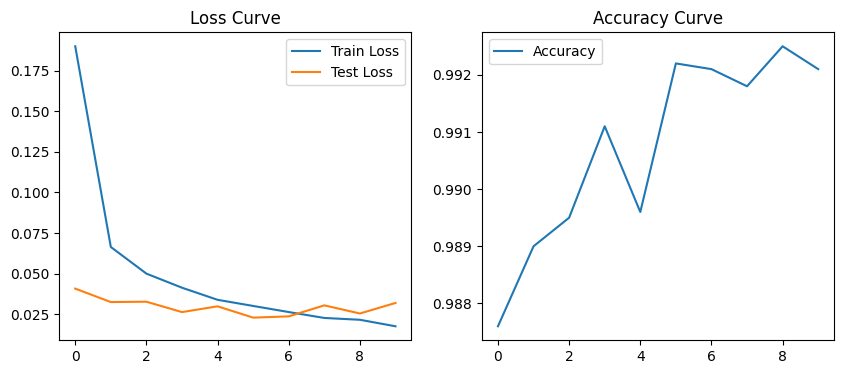

In [15]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(accuracies, label='Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

## Q3)

### Test KNN

In [22]:

class TestCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(TestCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.dropout = nn.Dropout(dropout_rate)

        self._to_linear = None
        self._init_linear_layer()

        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 10)

    def _init_linear_layer(self):
        with torch.no_grad():
            x = torch.zeros(1, 1, 28, 28)
            x = self.conv1(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2)
            x = self.conv2(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2)
            self._to_linear = x.view(1, -1).shape[1]

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [23]:
def train_and_evaluate(lr=0.001, batch_size=64, optimizer_name='Adam',
                       dropout_rate=0.5, weight_init='xavier'):
    from torchvision import datasets, transforms
    from torch.utils.data import DataLoader
    import torch.optim as optim


    transform = transforms.ToTensor()
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    # Model
    model = TestCNN(dropout_rate)

    # Starts Weight
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            if weight_init == 'xavier':
                nn.init.xavier_uniform_(m.weight)
            elif weight_init == 'he':
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    train_losses, test_losses, accuracies = [], [], []

    for epoch in range(1, 11):
        model.train()
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))

        # Test
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()

        test_losses.append(test_loss / len(test_loader))
        accuracy = correct / len(test_loader.dataset)
        accuracies.append(accuracy)
        print(f"[{optimizer_name} | LR={lr} | BS={batch_size} | Dropout={dropout_rate} | Init={weight_init}] "
              f"Epoch {epoch}: Accuracy = {accuracy:.4f}, Loss = {test_loss:.4f}")

    return accuracies, test_losses

### Test Calss and Save Results

In [24]:
results = {}

configs = [
    {'name': 'Adam_0.001_Drop0.3_Xavier', 'lr': 0.001, 'batch_size': 64, 'optimizer_name': 'Adam', 'dropout_rate': 0.3, 'weight_init': 'xavier'},
    {'name': 'SGD_0.01_Drop0.2_He',       'lr': 0.01,  'batch_size': 64, 'optimizer_name': 'SGD',  'dropout_rate': 0.2, 'weight_init': 'he'},
    {'name': 'Adam_0.005_Drop0.5_Xavier', 'lr': 0.005, 'batch_size': 128,'optimizer_name': 'Adam', 'dropout_rate': 0.5, 'weight_init': 'xavier'},
]

for config in configs:
    print(f"\nTraining config: {config['name']}")
    accs, losses = train_and_evaluate(
        lr=config['lr'],
        batch_size=config['batch_size'],
        optimizer_name=config['optimizer_name'],
        dropout_rate=config['dropout_rate'],
        weight_init=config['weight_init']
    )
    results[config['name']] = {'accuracy': accs, 'loss': losses}



Training config: Adam_0.001_Drop0.3_Xavier
[Adam | LR=0.001 | BS=64 | Dropout=0.3 | Init=xavier] Epoch 1: Accuracy = 0.9832, Loss = 0.5206
[Adam | LR=0.001 | BS=64 | Dropout=0.3 | Init=xavier] Epoch 2: Accuracy = 0.9890, Loss = 0.3363
[Adam | LR=0.001 | BS=64 | Dropout=0.3 | Init=xavier] Epoch 3: Accuracy = 0.9890, Loss = 0.3068
[Adam | LR=0.001 | BS=64 | Dropout=0.3 | Init=xavier] Epoch 4: Accuracy = 0.9906, Loss = 0.2717
[Adam | LR=0.001 | BS=64 | Dropout=0.3 | Init=xavier] Epoch 5: Accuracy = 0.9911, Loss = 0.2660
[Adam | LR=0.001 | BS=64 | Dropout=0.3 | Init=xavier] Epoch 6: Accuracy = 0.9920, Loss = 0.2522
[Adam | LR=0.001 | BS=64 | Dropout=0.3 | Init=xavier] Epoch 7: Accuracy = 0.9909, Loss = 0.2700
[Adam | LR=0.001 | BS=64 | Dropout=0.3 | Init=xavier] Epoch 8: Accuracy = 0.9916, Loss = 0.2854
[Adam | LR=0.001 | BS=64 | Dropout=0.3 | Init=xavier] Epoch 9: Accuracy = 0.9920, Loss = 0.2800
[Adam | LR=0.001 | BS=64 | Dropout=0.3 | Init=xavier] Epoch 10: Accuracy = 0.9927, Loss = 0.

###Graphs

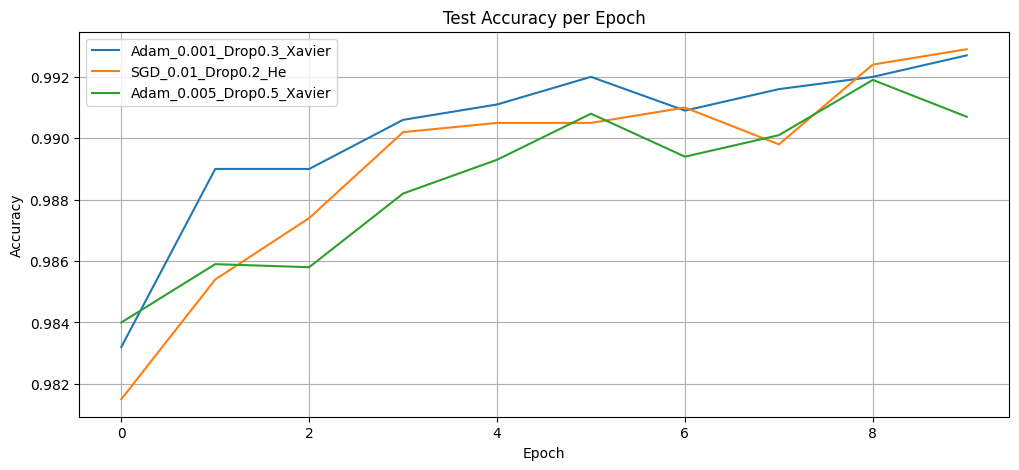

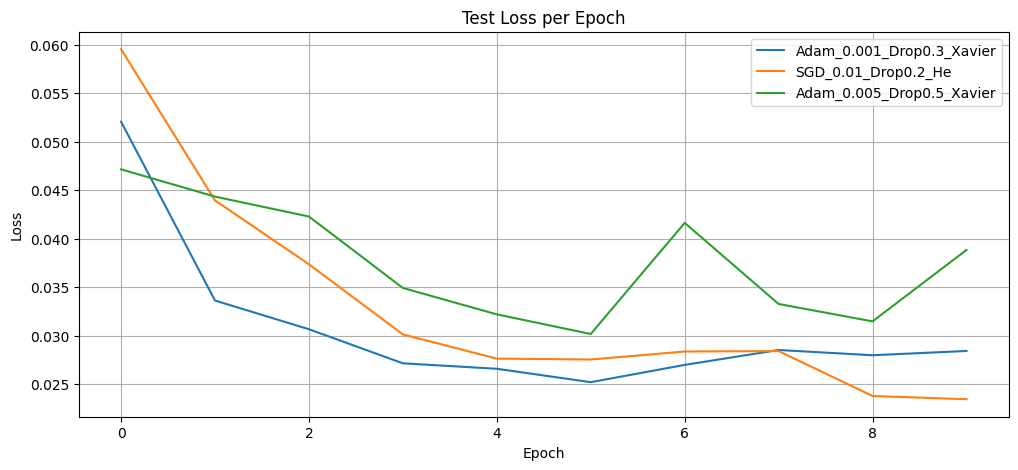

In [25]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12, 5))
for name, data in results.items():
    plt.plot(data['accuracy'], label=f"{name}")
plt.title("Test Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(12, 5))
for name, data in results.items():
    plt.plot(data['loss'], label=f"{name}")
plt.title("Test Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


###Find Best Configuration

In [26]:
best_config = max(results.items(), key=lambda x: max(x[1]['accuracy']))
best_acc = max(best_config[1]['accuracy'])

print(f"Best Configuration: {best_config[0]} with max accuracy = {best_acc:.4f}")


Best Configuration: SGD_0.01_Drop0.2_He with max accuracy = 0.9929


I noticed that the configuration using SGD with a learning rate of 0.01, He initialization, and 0.2 dropout gave me the best results. Compared to the others, it reached the highest accuracy and had the lowest test loss by the end of training. I think one of the reasons it worked so well is because He initialization fits nicely with ReLU, so the model started off with weights that made learning smoother. Also, even though Adam usually gives faster results in the beginning, SGD seemed to generalize better here. It didn’t just memorize the training data—it actually learned meaningful patterns. I also saw that using a lower dropout rate like 0.2 helped. When I used higher dropout like 0.5, the network kind of struggled to keep up during training. Finally, the learning rate of 0.01 seemed just right—fast enough to make progress but not too high to make it unstable. So overall, this combo just clicked better with my model and helped it perform the best.

##Q4)

###4.1) Constant Weights

In [27]:

class ConstantInitCNN(nn.Module):
    def __init__(self):
        super(ConstantInitCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.dropout = nn.Dropout(0.5)

        self._to_linear = None
        self._init_linear_layer()

        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 10)

        self.init_weights_constant()

    def _init_linear_layer(self):
        with torch.no_grad():
            x = torch.zeros(1, 1, 28, 28)
            x = self.conv1(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2)
            x = self.conv2(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2)
            self._to_linear = x.view(1, -1).shape[1]

    def init_weights_constant(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.constant_(m.weight, 0.5)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


####Training and Test

In [28]:
model = ConstantInitCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses, test_losses, accuracies = [], [], []

for epoch in range(1, 11):
    model.train()
    running_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Evaluation
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    test_losses.append(test_loss / len(test_loader))
    accuracy = correct / len(test_loader.dataset)
    accuracies.append(accuracy)

    print(f"[Constant Init] Epoch {epoch}: Accuracy = {accuracy:.4f}, Loss = {test_loss:.4f}")


[Constant Init] Epoch 1: Accuracy = 0.0974, Loss = 7171.3280
[Constant Init] Epoch 2: Accuracy = 0.0980, Loss = 511.5787
[Constant Init] Epoch 3: Accuracy = 0.1010, Loss = 52.1726
[Constant Init] Epoch 4: Accuracy = 0.1394, Loss = 23.3707
[Constant Init] Epoch 5: Accuracy = 0.1381, Loss = 22.8882
[Constant Init] Epoch 6: Accuracy = 0.1248, Loss = 22.8409
[Constant Init] Epoch 7: Accuracy = 0.1356, Loss = 22.8315
[Constant Init] Epoch 8: Accuracy = 0.1276, Loss = 22.8547
[Constant Init] Epoch 9: Accuracy = 0.1339, Loss = 22.8494
[Constant Init] Epoch 10: Accuracy = 0.1277, Loss = 22.8399


Instead, I set all the weights to 0.5. That means all the layers started with the same values. This was a big mistake because the output of every neuron in the model became identical.

### 4.2) Overfit and No Reqgularization

In [35]:
class OverfitCNN(nn.Module):
    def __init__(self):
        super(OverfitCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self._to_linear = None
        self._init_linear_layer()

        self.fc1 = nn.Linear(self._to_linear, 256)
        self.fc2 = nn.Linear(256, 10)

    def _init_linear_layer(self):
        with torch.no_grad():
            x = torch.zeros(1, 1, 28, 28)
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            x = self.pool(F.relu(self.conv4(x)))
            self._to_linear = x.view(1, -1).shape[1]

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


#### Training and Test

In [36]:
model = OverfitCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses, test_losses, accuracies = [], [], []

for epoch in range(1, 11):
    model.train()
    running_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Evaluation
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    test_losses.append(test_loss / len(test_loader))
    accuracy = correct / len(test_loader.dataset)
    accuracies.append(accuracy)

    print(f"[OverfitCNN] Epoch {epoch}: Accuracy = {accuracy:.4f}, Loss = {test_loss:.4f}")


[OverfitCNN] Epoch 1: Accuracy = 0.9869, Loss = 0.3933
[OverfitCNN] Epoch 2: Accuracy = 0.9885, Loss = 0.3554
[OverfitCNN] Epoch 3: Accuracy = 0.9893, Loss = 0.3309
[OverfitCNN] Epoch 4: Accuracy = 0.9914, Loss = 0.2988
[OverfitCNN] Epoch 5: Accuracy = 0.9901, Loss = 0.3291
[OverfitCNN] Epoch 6: Accuracy = 0.9926, Loss = 0.2894
[OverfitCNN] Epoch 7: Accuracy = 0.9924, Loss = 0.2611
[OverfitCNN] Epoch 8: Accuracy = 0.9921, Loss = 0.2725
[OverfitCNN] Epoch 9: Accuracy = 0.9930, Loss = 0.2927
[OverfitCNN] Epoch 10: Accuracy = 0.9878, Loss = 0.4932


Since the model is deep and has too much capacity, and without regularization, it fits the training data really well but can’t generalize to the test data. That’s why the test accuracy is much lower than the training accuracy.

###4.3)

In [39]:
class RMSDropCNN(nn.Module):
    def __init__(self):
        super(RMSDropCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.7)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)

        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


#### Training and Test

In [40]:
model = RMSDropCNN().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

train_losses, test_losses, accuracies = [], [], []

for epoch in range(1, 11):
    model.train()
    running_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Evaluation
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    test_losses.append(test_loss / len(test_loader))
    accuracy = correct / len(test_loader.dataset)
    accuracies.append(accuracy)

    print(f"[RMSDropCNN] Epoch {epoch}: Accuracy = {accuracy:.4f}, Loss = {test_loss:.4f}")


[RMSDropCNN] Epoch 1: Accuracy = 0.1028, Loss = 2381000.8125
[RMSDropCNN] Epoch 2: Accuracy = 0.1028, Loss = 1514001.1875
[RMSDropCNN] Epoch 3: Accuracy = 0.1736, Loss = 1023367.8359
[RMSDropCNN] Epoch 4: Accuracy = 0.0980, Loss = 1082760.5391
[RMSDropCNN] Epoch 5: Accuracy = 0.0980, Loss = 1148952.5391
[RMSDropCNN] Epoch 6: Accuracy = 0.0980, Loss = 1143192.1875
[RMSDropCNN] Epoch 7: Accuracy = 0.0980, Loss = 1115123.6328
[RMSDropCNN] Epoch 8: Accuracy = 0.0980, Loss = 1078234.9688
[RMSDropCNN] Epoch 9: Accuracy = 0.0980, Loss = 1022641.4531
[RMSDropCNN] Epoch 10: Accuracy = 0.0980, Loss = 967958.7656


Due to very high dropout and a very low learning rate, the model behaved as if it had lost its neurons.